In [79]:
from util.activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, activation_triggered_average, rescaleZeroOne, get_input_output_shape, multiplot
from receptive_fields.util.experiment_setup import open_experiment
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from receptive_fields.models.simple import SimpleCNN

import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchinfo import summary
import numpy as np
from util.image import fit_gabor_filter
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from util.image import weighted_hough_line
import os.path as osp
import yaml
import argparse

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [92]:
model_path = "../models/areadne_grid_factor4/stride_large_ks5"
model, train_data= open_experiment(model_path)
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)

in_channels = model.in_channels
img_size = model.img_size

# model_conf = model.config['config']
# model_conf['padding']=100
# model=SimpleCNN(**model_conf)

model = model.get_sequential()
summary(model, (1,in_channels,*img_size[::-1]))

Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 31, 41]           2,432
├─ELU: 1-2                               [1, 32, 31, 41]           --
├─Conv2d: 1-3                            [1, 32, 9, 11]            25,632
├─ELU: 1-4                               [1, 32, 9, 11]            --
├─Conv2d: 1-5                            [1, 32, 3, 4]             25,632
├─ELU: 1-6                               [1, 32, 3, 4]             --
├─Conv2d: 1-7                            [1, 32, 2, 2]             25,632
├─ELU: 1-8                               [1, 32, 2, 2]             --
├─Flatten: 1-9                           [1, 128]                  --
├─Linear: 1-10                           [1, 128]                  16,512
├─ELU: 1-11                              [1, 128]                  --
├─Linear: 1-12                           [1, 128]                 

In [82]:
model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(1, 1), padding=(5, 5))
  (1): ELU(alpha=1.0, inplace=True)
  (2): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (3): Conv2d(32, 32, kernel_size=(8, 8), stride=(1, 1), padding=(5, 5))
  (4): ELU(alpha=1.0, inplace=True)
  (5): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (6): Conv2d(32, 32, kernel_size=(8, 8), stride=(1, 1), padding=(5, 5))
  (7): ELU(alpha=1.0, inplace=True)
  (8): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (9): Conv2d(32, 32, kernel_size=(8, 8), stride=(1, 1), padding=(5, 5))
  (10): ELU(alpha=1.0, inplace=True)
  (11): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=192, out_features=128, bias=True)
  (14): ELU(alpha=1.0, inplace=True)
  (15): Linear(in_features=128, out_features=128, bias=True)
  (16): ELU(alpha=1.0, inplace=True)
  (17): Linear(in_features=128, out_features=128, bias=True)
  (18): ELU(alpha=1.0, inplace=True)
  (1

## Intermediate Representation

torch.Size([10, 32, 123, 163])


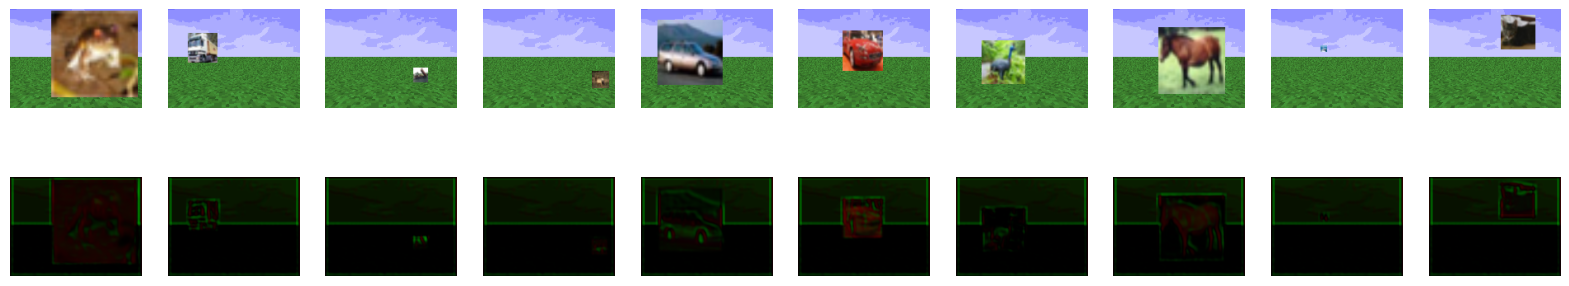

In [83]:
imgs = next(iter(train_loader))
processed = model[:2](imgs[0].to(device)).cpu().detach()
print(processed.shape)

fig, axes = plt.subplots(2, 10, figsize=(20,4))
for ax, im in zip(axes[0], imgs[0]):
    ax.imshow(im.movedim(0,2), cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], rescaleZeroOne(processed)):
    ax.imshow(im.movedim(0,2)[...,:3], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

## Receptive Fields

100%|██████████| 32/32 [00:00<00:00, 564.27it/s]


<Figure size 500x500 with 0 Axes>

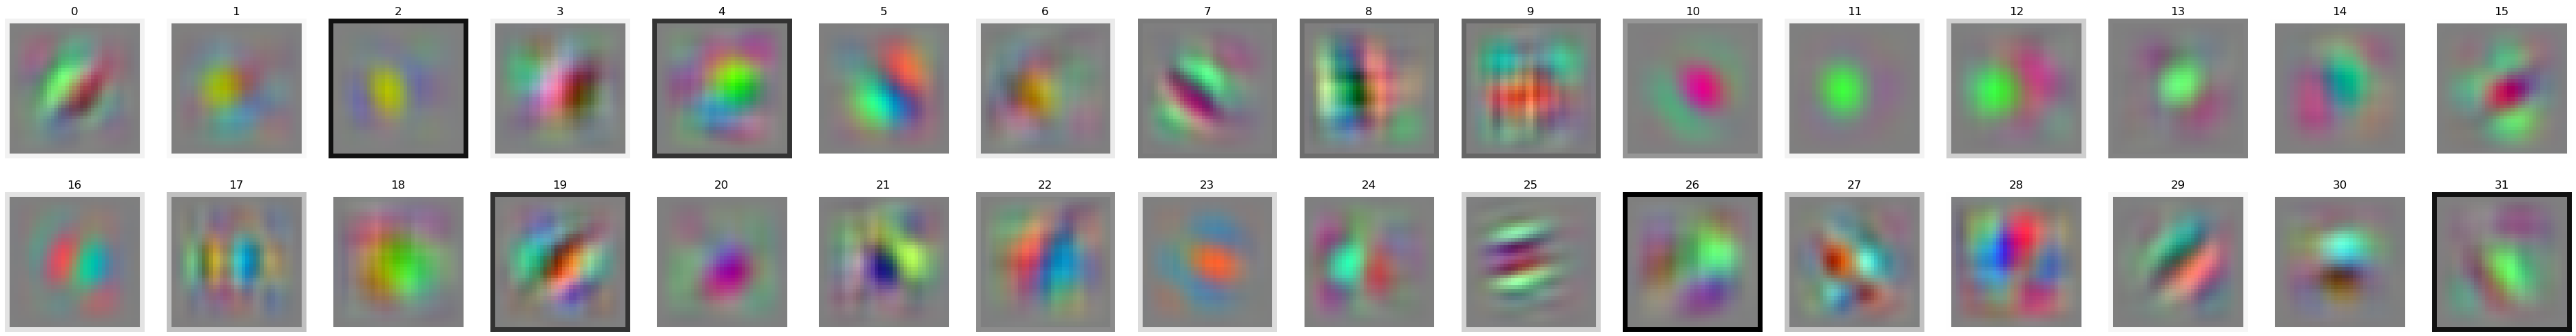

In [90]:
eff_rfs = effective_receptive_field(model[:6], n_batch=1, fill_value=0.5, device=device) # model[0].weight.detach().cpu()# TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
order = torch.argsort(eff_rfs.abs().sum(axis=(1,2,3)), descending=True)
# eff_rfs = eff_rfs[order]
plt.figure(figsize=(5,5))
multiplot(eff_rfs, color=True, individ_rescale=True, plots_per_row=16, max_plots=32)

In [85]:
stop

NameError: name 'stop' is not defined

In [ ]:
def plot_hough(image, h, theta, d, rf_edges, hpeaks):
    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    ax = axes.ravel()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step),
            d[-1] + d_step, d[0] - d_step]
    ax[0].imshow(h, extent=bounds)
    ax[0].set_title('Hough transform')
    ax[0].set_xlabel('Angles (degrees)')
    ax[0].set_ylabel('Distance (pixels)')
    ax[0].axis('image')

    ax[1].imshow(image, cmap='gray')
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines')

    ax[2].imshow(rf_edges, cmap='gray')
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Edges')

    for _, angle, dist in zip(*hpeaks):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        slope = np.tan(angle + np.pi/2)
        ax[1].axline((x0, y0), slope=slope)
        ax[2].axline((x0, y0), slope=slope)

    plt.tight_layout()
    plt.show()

In [ ]:
image = eff_rfs[19]
rf_edges = np.zeros_like(image)
rf_edges[:] = image.numpy()#sobel(image.numpy())
rf_edges[np.abs(rf_edges)<np.mean(np.abs(rf_edges))]=0
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges_pos = rf_edges

# rf_edges = sobel(-image.numpy())
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges = rf_edges + rf_edges_pos

# rf_edges_nms = torch.max_pool2d(torch.from_numpy(rf_edges)[None], kernel_size=3, stride=1, padding=1).numpy()
# rf_edges = rf_edges_nms[0]
n_thetas = 180
thetas = (np.array([i+0.5 for i in range(n_thetas)])/n_thetas*2*np.pi - np.pi)/2
h, theta, d = weighted_hough_line(rf_edges, theta=thetas)
h=h**2
hpeaks = hough_line_peaks(h, theta, d, num_peaks=1) # TODO: Use probabilistic Hough line for connected lines?
print(hpeaks[1]/np.pi)

plot_hough(image, h, theta, d, rf_edges, hpeaks)

IndexError: index 19 is out of bounds for dimension 0 with size 16

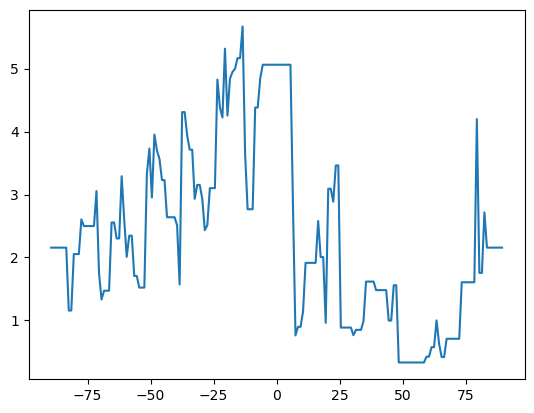

In [ ]:
plt.plot(thetas/np.pi*180,(h).sum(axis=0))
plt.show()

The following cell should be run only with a GPU backend!

Other than that, it seems that the activation triggered average results in 'nicer' RFs for the first layer, in higher layers the effective receptive fields are usually smoother (and a lot faster!)

In [ ]:
cmap = plt.get_cmap('viridis_r')

32it [00:06,  4.63it/s]


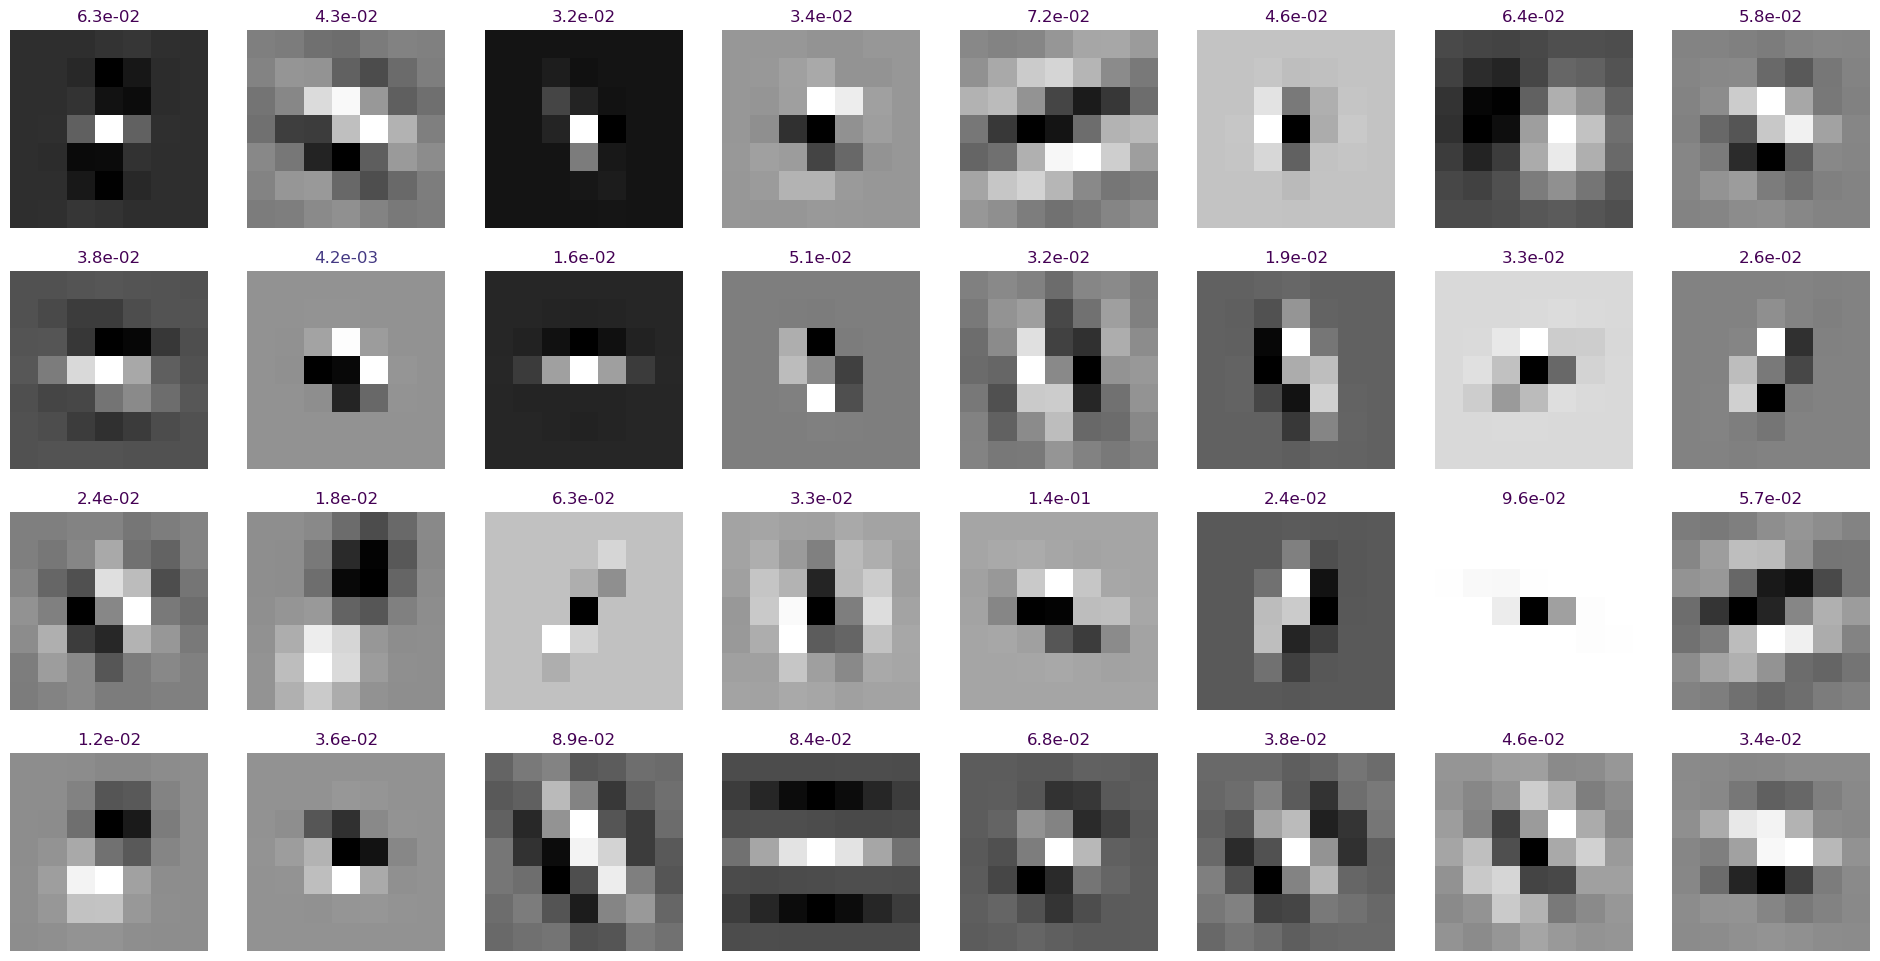

In [ ]:
num_rows = max(1,len(eff_rfs)//8)
fig, axes = plt.subplots(num_rows, 8, figsize=(24,num_rows*3))
all_fitted=[]
for eff_rf, ax in tqdm(zip(eff_rfs, axes.flat)):
    fitted = fit_gabor_filter(eff_rf.numpy(), wavelength=8, maxiter=1000)
    all_fitted.append(fitted)
    ax.imshow(fitted[0], cmap="gray")
    ax.set_title('{:.1e}'.format(fitted[1]), color=cmap(fitted[1]/0.005))
    ax.axis('off')

In [ ]:
eff_rfs = dataset_average(model[:5], train_loader, device=device) # TODO: Also buggy? :D

if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    fig, axes = plt.subplots(4, 8, figsize=(24,12))
    for eff_rf, ax in zip(eff_rfs, axes.flat):
        ax.imshow(torch.mean(eff_rf, dim=0), cmap="gray")
        ax.axis('off')

  3%|▎         | 1/32 [00:25<13:08, 25.44s/it]


KeyboardInterrupt: 

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


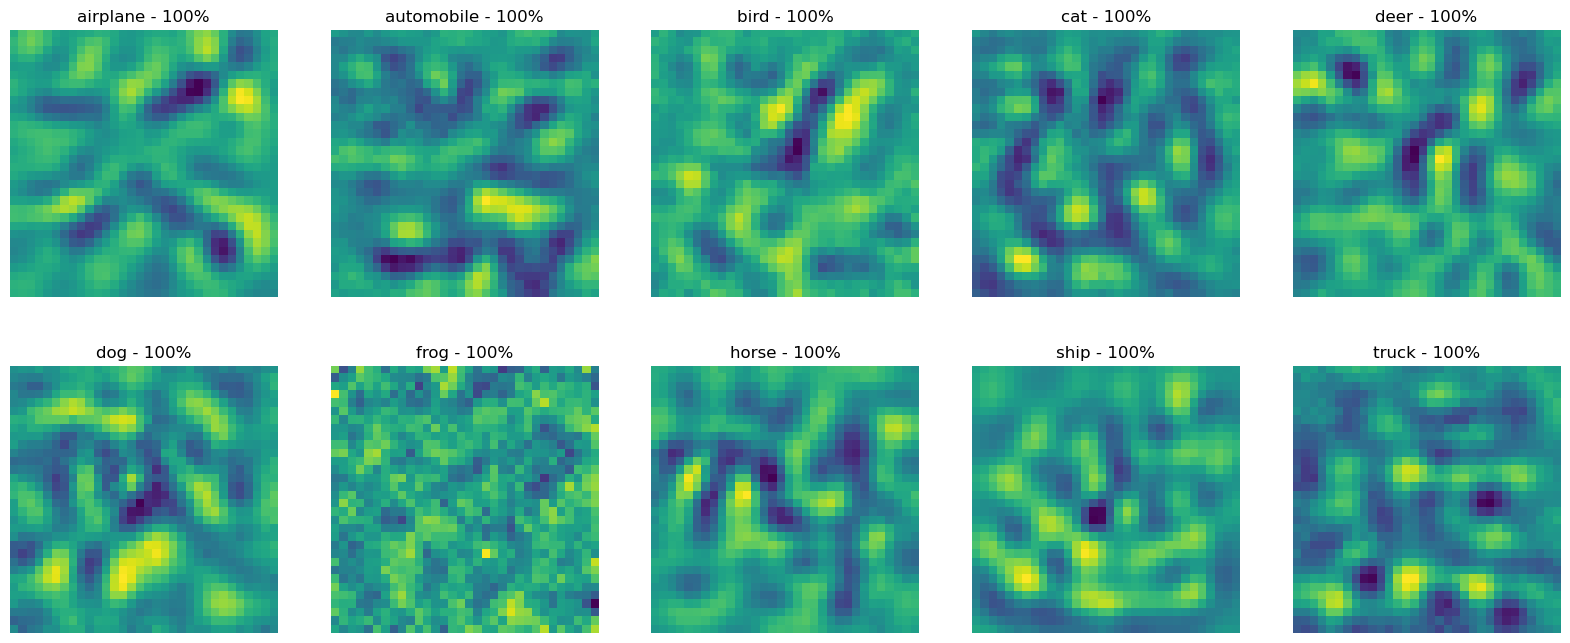

In [ ]:
back_maxs = backprop_maximization(model[:-1], n_iter=128, batch_size=1, reduction=True, smoothened=True, device=device)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, back_max, ax in zip(train_data.classes, back_maxs, axes.flat):
    out = model(back_max.repeat(1,1,1,1).to(device))
    index = out.argmax()
    prob = out.max()

    ax.imshow(back_max.movedim(0,2).cpu())
    ax.axis('off')
    ax.set_title(class_name + " - {0:.0%}".format(prob))

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


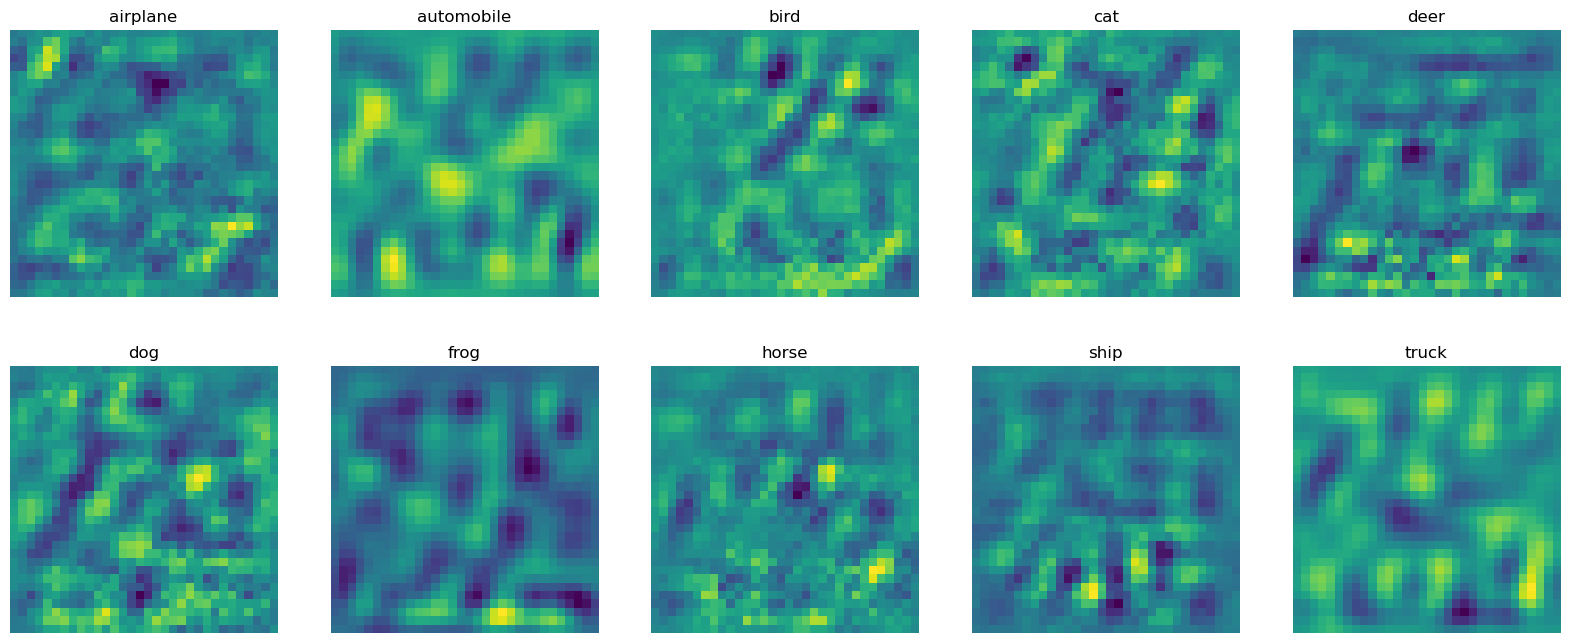

In [ ]:
eff_rfs = effective_receptive_field(model, n_batch=2048, device=device)
fig, axes = plt.subplots(2, 5, figsize=(20,8))

for class_name, eff_rf, ax  in zip(train_data.classes, eff_rfs, axes.flat):
    ax.imshow(rescaleZeroOne(eff_rf.movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)